# Guiana Chestnut algorithms
This notebook will aim to build several algorithms for fundamental and technical analysis of stocks on the S&Q 500 Index. However, it can be applied to other stocks as well.

We will be using the following packages/APIs to formulate our algorithms:
- [finnhub.io](https://finnhub.io/docs/api)
- [yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/)

### Packages
Please ensure these packages are installed on your local environment via ```pip install -r requirements.txt``` or the corresponding package manager on your OS.

In [27]:
import csv
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

import finnhub as fh
import yfinance as yf
import yahoo_fin.stock_info as si
import spacy
import cryptography
from spacytextblob.spacytextblob import SpacyTextBlob

%matplotlib inline

### 0. Auxiliary functions

We first define various functions for gathering the data from finnhub.io which we will use for training our algorithms.

Finnhub.io requires a client object to connect to their API. Please register for a free API key if you don't have one.

In [28]:
key = os.environ.get('FINNHUB_API_KEY')
client = fh.Client(api_key=key)
client

In [29]:
def get_ticker_financial_data(symbol, client):
    """
    Builds a pandas dataframe containing the essential financial data of a US stock symbol.
    @params symbol: a registered US stock symbol (ticker symbol).
    @params client: a finnhub.io Client instance initialized with your finnhub.io API key.
    @return: pandas Dataframe
    """

    # Extract company profile
    company_profile_dict = client.company_profile2(symbol=symbol)
    del company_profile_dict['logo'], company_profile_dict['phone'], company_profile_dict['weburl'], company_profile_dict['ticker']
    company_profile = pd.Series(company_profile_dict)

    # Extract company financial metrics
    company_financials_metrics = client.company_basic_financials(symbol=symbol, metric='all')['metric']
    company_financials = pd.Series(company_financials_metrics)    

    data = pd.concat([company_profile, company_financials])
    return pd.DataFrame(data)

def get_ticker_news_data(symbol, client, date_format, days):
    """
    Builds a list of news summaries for a US stock symbol.
    @params symbol: a registered US stock symbol (ticker symbol).
    @params client: a finnhub.io Client instance initialized with your finnhub.io API key.
    @return: List of news headlines for further processing
    """

    today       = datetime.datetime.now(datetime.timezone.utc).replace(tzinfo=datetime.timezone.utc).timestamp()
    date_delta  = today - days * 24 * 60 * 60
    start_date  = datetime.datetime.fromtimestamp(date_delta).strftime(date_format)
    today_date  = datetime.datetime.fromtimestamp(today).strftime(date_format)

    news        = client.company_news(symbol=symbol, _from=start_date, to=today_date)
    return news

def get_ticker_financials_as_reported(symbol, client):
    return client.financials_reported(symbol=symbol, freq='annual')['data']

Testing to see if the functions work

In [30]:
get_ticker_financial_data('AAPL', client)

,0
country,US
currency,USD
exchange,NASDAQ NMS - GLOBAL MARKET
finnhubIndustry,Technology
ipo,1980-12-12
...,...
tangibleBookValuePerShareQuarterly,3.17824
tbvCagr5Y,-17.6806
totalDebt/totalEquityAnnual,238.8104
totalDebt/totalEquityQuarterly,236.9534


### 1. Fundamental - Sentiment analysis on news articles

We can estimate how positive a news report is using sentiment analysis. This can be useful later on for finding the correlation between the positivity of a piece of news and the price trends of a symbol. We will be using the spaCy library for performing sentiment analysis on a given piece of news. Run the following command to install the en package which is required for spaCy:

In [31]:
! python -m spacy download en_core_web_sm
! python -m spacy download en_core_web_lg

     --------------------------------------- 12.8/12.8 MB 27.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-12-23 15:22:31.816849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-12-23 15:22:31.817510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 15:22:37.076273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-12-23 15:22:37.078781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-12-23 15:22:37.081314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-12-23 15:22:37.083839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

^C


With the english package installed, we can now perform sentiment analyisis.

Important sentiment terms:

- Polarity refers to the orientation of the expressed statement. It should be a float between 1 (positive) and -1 (negative).
- Subjectivity refers to the amount of personal bias in the expressed statement. It should be a float between 0 (personal) and 1 (public).

In [32]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('spacytextblob')

In [33]:
symbol = 'AAPL'

In [34]:
def get_ticker_news_sentiment_analysis(symbol, client):

    polarities, subjectivities, dates = [], [], []

    ticker_news = get_ticker_news_data(symbol, client, days=20, date_format="%Y-%m-%d")

    for news in reversed(ticker_news):
        news_summary, news_date = news['summary'], news['datetime']

        # For now, assume that weekend news doesn't affect the monday share price.
        weekday = datetime.datetime.fromtimestamp(news_date).weekday()

        # if weekday != 5 and weekday != 6:
        result = nlp(news_summary)
        news_sentiment = result._.blob.sentiment
        news_polarity, news_subjectivity = news_sentiment.polarity, news_sentiment.subjectivity
        polarities.append(news_polarity)
        subjectivities.append(news_subjectivity)
        dates.append(datetime.datetime.fromtimestamp(news_date).strftime("%Y-%m-%d"))
    
    return polarities, subjectivities, dates

In [35]:
polarities, subjectivities, dates = get_ticker_news_sentiment_analysis(symbol, client)
pd.DataFrame.from_dict({'Date': dates, 'Polarity': polarities, 'Subjectivity': subjectivities})

,Date,Polarity,Subjectivity
0,2022-12-13,0.387500,0.487500
1,2022-12-13,-0.116667,0.466667
2,2022-12-13,0.068182,0.300000
3,2022-12-13,0.076667,0.413333
4,2022-12-13,0.000000,0.000000
...,...,...,...
232,2022-12-23,0.000000,0.000000
233,2022-12-23,0.250000,0.750000
234,2022-12-23,0.333333,0.316667
235,2022-12-23,0.125000,0.375000


Let's also plot the polarities against the dates to see if there is any trend

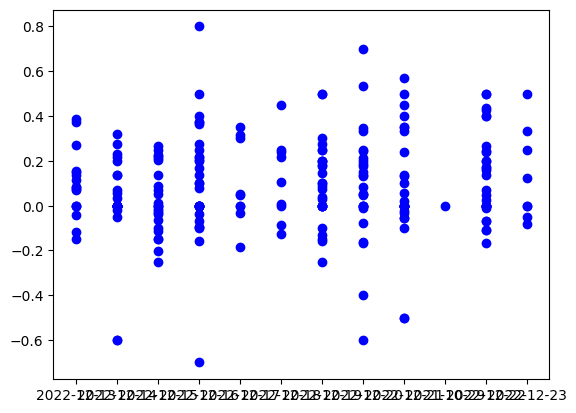

In [36]:
plt.scatter(dates, polarities, c='blue')

### 3. Fundamnetal - Piotroski F-score
The Piotroski F-score is a number between 0 and 9 which is used to access the strength of a company's financial position. This score is used by financial investors in order to find the best value stocks (9 being the best).

The score is calculated based on 9 criteria divided into 3 groups:

#### Profitability
1. Return on assets (1 if positive this year, 0 otherwise)
2. Operating cash flow (1 if positive this year, 0 otherwise)
3. Change in Return of Assets (ROA) (1 if higher than last year, 0 otherwise)
4. Accruals (1 if Operating Cash Flow Total Assets is higher than ROA this year, 0 otherwise)
   
#### Leverage, Liquidity & Source of Funds
1. Change in Leverage (long-term) ratio (1 if ratio lower than last year, 0 otherwise)
2. Change in Current Ratio (1 if ratio is higher than last year, 0 otherwise)
3. Change in the number of shares (1 if no new shares were issued during the last year, 0 otherwise)

#### Operating Efficiency
8. Change in Gross Margin (1 if higher than last year, 0 otherwise)
9. Change in Asset Turnover Ratio (1 if higher than last year, 0 otherwise)

Resource: https://en.wikipedia.org/wiki/Piotroski_F-score


### Create functions for calculating Piotroski F-score criteria
We will use the [yahoo_fin](http://theautomatic.net/yahoo_fin-documentation/) package to calculate Piotroski F-scores for each symbol in the S&Q 500 Index.

In [37]:
class PiotroskiFScore:
    def __init__(self, tickers):
        self.tickers = tickers
    

    def get_data(self, ticker):
        """
        Extract financial metrics for Piotroski F-score calculation.
        """
        balance_sheet   = ticker.balance_sheet
        income_smt      = None
        cfs             = ticker.cashflow
        years           = balance_sheet.columns
        print(balance_sheet)
        print(cfs)
        print(years)
        return balance_sheet, income_smt, cfs, years
    

    def get_profitability_score(self, balance_sheet, income_smt, cfs, years):
        """
        Return a score between 0 and 5 for the 5 criteria on profitability.
        """
        # Scores 1 & 2 - Net income
        net_income      = income_smt[years[0]]['netIncome']
        net_income_py   = income_smt[years[1]]['netIncome']
        ni_score        = 1 if net_income > 0 else 0
        ni_delta_score  = 1 if net_income > net_income_py else 0

        # Score 3 - Operating cash flow
        op_cf           = cfs[years[0]]['totalCashFromOperatingActivities']
        op_cf_score     = 1 if op_cf > 0 else 0

        # Score 4 - Change in RoA
        avg_assets      = (balance_sheet[years[0]]['totalAssets'] + balance_sheet[years[1]]['totalAssets']) / 2
        avg_assets_py   = (balance_sheet[years[1]]['totalAssets'] + balance_sheet[years[2]]['totalAssets']) / 2
        roa             = net_income / avg_assets
        roa_py          = net_income_py / avg_assets_py
        roa_score       = 1 if roa > roa_py else 0

        # Score 5 - Accurals
        total_assets    = balance_sheet[years[0]]['totalAssets']
        accurals        = op_cf / total_assets - roa
        acc_score       = 1 if accurals > 0 else 0

        # Return a score between 0 and 5 (for 5 criteria on profitability)
        return ni_score + ni_delta_score + op_cf_score + roa_score + acc_score
    
    def get_piotroski_fscore(self, ticker):
        """
        Calculate the Piotroski F-score for a single ticker.
        """
        balance_sheet, income_smt, cfs, years = self.get_data(ticker)
        profitability_score     = self.get_profitability_score(balance_sheet, income_smt, cfs, years)
    

    def get_all_piotroski_fscores(self):
        """
        Calculate the Piotroski F-score for all tickers provided from initialisation.
        """
        pf_scores       = {}
        for ticker in self.tickers:
            symbol = ticker
            ticker = yf.Ticker(symbol)
            pf_scores[symbol] = self.get_piotroski_fscore(ticker)
        return pf_scores

Test the above class on the S&Q 500 Index symbols.

In [59]:
sq500     = si.tickers_sp500(include_company_data=False)
pf_scores = PiotroskiFScore(["AAPL"]).get_all_piotroski_fscores()
print(pf_scores)

AttributeError: 'Ticker' object has no attribute 'get_incomestmt'